# **Reinforcement Learning Project**
# Deep reinforcement learning for energy management systems in a microgrid
---
---
### Installing Dependencies

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from collections import deque

from gym import spaces
from gym.utils import seeding
import pandas as pd

from tensorflow import keras
import tensorflow as tf

import sys, os; os; os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2" 
import tensorflow, numpy, glob
import numpy as np

### Introduction

Inadequate control over residential electrical energy usage can result in many adverse consequences, which extend beyond individual residences and have implications for the broader environmental and societal spheres. The negative effects may encompass environmental, economic, and social ramifications.

Mismanagement of residential electrical energy consumption can result in escalated household energy expenses from an economic standpoint. It can cause financial strain and tension, particularly for low-income families, by straining household budgets. Moreover, it can potentially exacerbate energy poverty, a condition in which households cannot afford sufficient energy services, negatively affecting their overall well-being and quality of life (Boeri et al., 2020). Therefore, an energy management system becomes an urgent need.

The question is, how can we optimize the use of household electrical energy intelligently and efficiently? We must utilize artificial intelligence in energy management, especially reinforcement learning, with a Deep Q-Network (DQN) approach. Reinforcement learning can study the interactions that occur in home energy use by understanding home occupants' habits and producing appropriate energy consumption policies.

In this tutorial, we will explore practical steps using Python to build a DQN algorithm to determine appropriate household energy consumption actions. Through this approach, we seek efficient solutions to reduce electricity bills and contribute positively to overall electricity resource management. Let's start by understanding the environment and the steps necessary to achieve this goal.

**Microgrids**

Microgrids – self-contained electrical grids that are capable of disconnecting from the main grid – hold potential in both tackling climate change mitigation via reducing CO
 emissions and adaptation by increasing infrastructure resiliency. Due to their distributed nature, microgrids are often idiosyncratic; as a result, control of these systems is nontrivial.

 While microgrid simulators exist, many are limited in scope and in the variety of microgrids they can simulate. We propose pymgrid, an open-source Python package to generate and simulate a large number of microgrids, and the first open-source tool that can generate more than 600 different microgrids. pymgrid abstracts most of the domain expertise, allowing users to focus on control algorithms.

 In particular, pymgrid is built to be a reinforcement learning (RL) platform, and includes the ability to model microgrids as Markov decision processes
 pymgrid also introduces two pre-computed list of microgrids, intended to allow for research reproducibility in the microgrid setting.

**The first step** is to extract the file named 'data.zip' and then extract the entire contents into the '/content/' directory, so that if there are files or folders in the zip, they will all be placed in the '/content/' directory.

In [ ]:
!git  clone --depth=1 git@github.com:heringo/EMS.git
!mv /content/EMS/data/ /content/data
!rm --r /content/EMS

Cloning into 'HEM-DeepRL-v2'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 50 (delta 0), reused 45 (delta 0), pack-reused 0
Receiving objects: 100% (50/50), 6.03 MiB | 17.39 MiB/s, done.


**MODELING THE PROBLEM : HOME ENERGY MANAGEMENT SYSTEM**

To enhance realism, we address the Energy Management System (EMS) of a household. The problem involves two available power sources for the Reinforcement Learning (RL) agent:
- Microgrid
- Photovoltaic

Utilizing these power sources, the RL agent can opt to charge two types of batteries:
- House battery
- Electric Vehicle (EV) battery

Home constraints include:
- Energy demand for the house varies based on the time of day.

Electric Vehicle Constraints:
- The EV cannot be charged between 7 am and 10 pm daily, reflecting the owner's consistent use throughout the day. (Negative Reward : -10 for charging during the day)
- The EV must have a minimum charge of 11% daily to be operational. (Negative reward : -10 for not enough battery)

Charging Constraints:
- One hour of charging results in an 11% increase in battery charge. (Negative reward : -1 for each dollar)



### Env : Smart Home


### Defining Constants

Next, define three classes that store constants or specifications in a simulation or model.
1. **Actions class:** provides constants representing various actions to be taken in a simulation. A numeric value, such as NO_ACTION, CHARGE_HOME_wPV, CHARGE_HOME_wSG, CHARGE_EV_wPV, and CHARGE_EV_wSG represent each action. For example, CHARGE_HOME_wPV can be interpreted as the action of charging at home using photovoltaic (PV).

2. **Specifications class:** provides constants and specifications used in the simulation or model. Some of the constants include HOME_CAPACITY, which indicates the power capacity of the home, EV_CAPACITY which means the power capacity of the electric vehicle (EV), EV_DAILY_CONSUME which is the daily consumption of the EV, EV_CHARGE_WINDOW which indicates the EV charging time window, and MAX_CHARGE_FOR_HOUR which is the maximum limit of charging for an hour.

3. **Constant class:** provides other constants used in the simulation. For example, MONTHS_LEN contains the number of days each month, and MAX_STEP_HOURS is the number of monthly hours. These constants can be used to set parameters and conditions in the simulation.

In [ ]:
#Constant that indicates which actions is taken
class Actions:
	NO_ACTION = 0
	CHARGE_HOME_wPV = 1         #Charging Home with Photovoltaic
	CHARGE_HOME_wSG = 2         #Charging Home with SmartGrid

	CHARGE_EV_wPV = 3           #Charging EV with Photovoltaic
	CHARGE_EV_wSG = 4           #Charging EV with SmartGrid

class Specifications:
	HOME_CAPACITY = 100
	EV_CAPACITY = 100
	EV_DAILY_CONSUME = 11
	EV_CHARGE_WINDOW = [18, 6]      #Charging when the EV is at home and not use
	MAX_CHARGE_FOR_HOUR = 11

class Constant:
	MONTHS_LEN = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
	MAX_STEP_HOURS = 24 * 30


### Class to preprocess PV entry, SG prices and H4 consumes

The ProcessedData class below is for managing data related to photovoltaic production, SmartGrid electricity prices, and household consumption/needs at specified time intervals. Here is an explanation for each part of this class:

**Class Attributes:**
PV_production: A list attribute used to store photovoltaic production data.
SG_prices: A list attribute used to store SmartGrid electricity price data.
H4_consumes: A list attribute used to store consumption or household needs data.

**Class Methods:**
__init__(self): Initialization method (constructor) that is called when a class object is created. This method initializes the PV_production, SG_price, and H4_usage list attributes as an empty list.

add_PV(self, el): Method for adding elements to the PV_production list.
add_SG(self, el): Method for adding elements to the SG_price list.
add_H4(self, el): Method for adding elements to the usage_H4 list.

get_PV(self, month, day, hour): Method for getting photovoltaic production values for a specific month, day and hour.
get_SG(self, month, day, hour): Method for getting SmartGrid electricity price values for a specific month, day and hour.
get_H4_consumes(self, month, day, hour): Method for getting consumption values/household needs for a certain month, day and hour.

The get_PV, get_SG, and get_H4_consumes methods take month, day, and hour parameters to calculate the appropriate index in the data list based on a specific date and time. The formula used to calculate the index involves the total number of hours before a specific date and time. In this context, we assume that Constant.Month_length contains the number of days in each month, so sum(Constant.Month_length[:month-1]) can provide the total number of days of the previous months. So, this formula is used to calculate the appropriate index in the data list for a certain date and time.

In [ ]:
class ProcessedData:
	def __init__(self):
		self.PV_production = []                       #Production of Photovoltaic
		self.SG_prices = []                           #Price of SmartGrid Electricity
		self.H4_consumes = []                         #The consumption/need of the home

	# Methods to add the elements in the specific arrays
	def add_PV_entry(self, el): self.PV_production.append( el )
	def add_SG_prices(self, el): self.SG_prices.append( el )
	def add_H4_consumes(self, el): self.H4_consumes.append( el )

	# Get Methods (given month and time return the value)
  # To get the element it converts every day in hours
	def get_PV_entry(self, month, day, day_time): return self.PV_production[ (sum(Constant.MONTHS_LEN[:month-1]) + day - 1) * 24  + day_time ]
	def get_SG_prices(self, month, day, day_time): return self.SG_prices[ (sum(Constant.MONTHS_LEN[:month-1]) + day - 1) * 24  + day_time ]
	def get_H4_consumes(self, month, day, day_time): return self.H4_consumes[ (sum(Constant.MONTHS_LEN[:month-1]) + day - 1) * 24  + day_time ]

### Function for plotting

The LinePlotter class creates and renders line plots with several additional features. The following is an explanation for each part of the class:

**Constructor (__init__)**:
Initializes the object with an x-axis label (x_label), y-axis label (y_label), and plot title (title).
Create a subplot object using plt.subplot(1).
It hides the top and right edges of the plot.
Sets the background color of the plot.
Adds a grid to the plot with white lines.
Set the font size for the x and y axes, axis labels, and titles.

**load_array**:
Loads some array of data from the given files.
Sets the array's length (shortest of all arrays) as array_len.
Store data arrays as data_arrays.

**render**:
Render a line plot with the mean, maximum value, and minimum value of each data array.
Use fill_between to display the area between the maximum and minimum values.
A legend was added at the bottom right of the plot.
Displays plots.

**process_data**:
Processing data, including calculating the rolling mean, standard deviation, maximum, and minimum values.
Using a rolling window to calculate the rolling mean.
Determines the x-axis (x_axes) based on the length of the data array.
Stores each data array's average value, standard deviation, maximum value, and minimum value.

**Variables**

fig and ax: Variables that store subplot objects.
data_arrays: Multidimensional arrays that store data.
array_len: Length of the data array.
mean_array, var_array, max_array, min_array: Arrays that store the mean, standard deviation, maximum value, and minimum value.
x_axes: Variable that stores the x-axis for the plot.

In [ ]:
class LinePlotter:

	def __init__(self, x_label="X Label", y_label="Y Label", title="No Title"):
		self.fig, self.ax = plt.subplots(1)
		self.ax.spines["top"].set_visible(False)
		self.ax.spines["bottom"].set_visible(False)
		self.ax.spines["right"].set_visible(False)
		self.ax.spines["left"].set_visible(False)
		self.ax.set_facecolor('#eaeaf2')
		plt.grid(color='#ffffff', linestyle='-', linewidth=1)
		plt.xticks(fontsize=12)
		plt.yticks(fontsize=12)
		plt.xlabel(x_label, fontsize=12)
		plt.ylabel(y_label, fontsize=12)
		plt.title(title, fontsize=16)
		self.data_arrays = []
		self.array_len = -1
		self.mean_array = []
		self.var_array =  []
		self.max_array = []
		self.min_array = []

	def load_array(self, file_name_arrays, early_stop=None):
		data_arrays = [[np.loadtxt(name, delimiter=' ', unpack=True) for name in array_set] for array_set in file_name_arrays]
		if(early_stop == None): self.array_len = min([min([len(el) for el in array_set]) for array_set in data_arrays])
		else: self.array_len = early_stop
		self.data_arrays = np.array([[el[:self.array_len] for el in array_set] for array_set in data_arrays], dtype=object)

	def render(self, labels, colors):
		err_msg = "load some data before the render!"
		assert self.array_len > 0, err_msg
		for mean_values, max_values, min_values, label, color in zip(self.mean_array, self.max_array, self.min_array, labels, colors):
			self.ax.plot(self.x_axes, mean_values, label=label, color=color, linestyle='-', linewidth=1.2 )
			self.ax.fill_between(self.x_axes, max_values, min_values, facecolor=color, alpha=0.3)
		self.ax.legend(loc='lower right', bbox_to_anchor=(1, 0), fontsize=14)
		plt.show()

	def process_data(self, rolling_window=1, starting_pointer=0, early_stop=None):
		rolling_queue = deque(maxlen=rolling_window)
		self.x_axes = [i for i in range(self.array_len-starting_pointer)]
		for array_set in self.data_arrays:
			for array in array_set:
				for i in range(self.array_len):
					rolling_queue.append(array[i])
					array[i] = np.mean(rolling_queue)
				rolling_queue.clear()
		# Fix for different array size
		self.data_arrays = np.array([np.array(el) for el in self.data_arrays], dtype=object)
		self.mean_array = np.array([[np.mean(array_set[:, i]) for i in range(self.array_len)][starting_pointer:] for array_set in self.data_arrays])
		self.var_array =  np.array([[np.std(array_set[:, i]) for i in range(self.array_len)][starting_pointer:] for array_set in self.data_arrays])
		self.max_array = [[np.max(array_set[:, i]) for i in range(self.array_len)][starting_pointer:] for array_set in self.data_arrays]
		self.min_array = [[np.min(array_set[:, i]) for i in range(self.array_len)][starting_pointer:] for array_set in self.data_arrays]


HistoPlotter class to display histograms based on two data sets, trained_list and random_list, to visually represent how these data sets differ or align. The class constructor (__init__) is used to initialize the class objects, with two attributes (trained_list and random_list) which are initialized as empty lists. They will be used to store data that will be plotted in a histogram. The plot method creates and displays a histogram plot that compares two data sets (trained_list and random_list) for individual months ("January" to "December") with the following functionality:
*   Create an image (fig) and a subplot (ax) using Matplotlib.
*   Count the number of elements in the trained_list and create an index array (indices) using NumPy.
*   Create two histogram bars (rects1 and rects2) using data from trained_list and random_list.
*   Use prepared data to set several properties on the plot, such as axis labels and title.




In [ ]:
class HistoPlotter():

	def __init__(self):
		self.trained_list = []
		self.random_list = []

	def plot( self ):
		fig = plt.figure()
		ax = fig.add_subplot(111)
		N = len(self.trained_list)
		ind = np.arange(N)
		width = 0.35
		rects1 = ax.bar(ind, self.trained_list, width,
						color='black',
						error_kw=dict(elinewidth=2,ecolor='Red'))
		rects2 = ax.bar(ind+width, self.random_list, width,
							color='red',
							error_kw=dict(elinewidth=2,ecolor='Blue'))
		ax.set_xlim(-width,len(ind)+width)
		ax.set_ylabel('Money Spent (euros)', fontsize=12)
		ax.set_title('Smart Home')
		xTickMarks = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
		ax.set_xticks(ind+width)
		xtickNames = ax.set_xticklabels(xTickMarks)
		plt.setp(xtickNames, rotation=45, fontsize=12)
		ax.legend( (rects1[0], rects2[0]), (f"Trained Network (total={sum(self.trained_list):6.2f})", f"Random Actions (total={sum(self.random_list):6.2f})"), fontsize=14 )
		plt.show()

The DoubleLinePlotter class creates plots with two y-axes that share the x-axes. The first y-axis describes the battery consumption from Solar Grid (SG) and Photovoltaic (PV) resources, while the second y-axis describes the energy prices. Explanations of all parts of this class are:


*   The constructor initializes the objects with some default parameters that are given and initialized as object attributes, including battery level (battery_level), electric vehicle level (ev_level), energy price (price), hourly cost of SG (hourly_charge_sg), and hourly cost of PV (hourly_charge_pv).
*   The plot method creates and displays plots with two y axes. The subplot (ab) and twin axes (ab.twinx()) objects represent two y-axes that share the x-axis to provide additional space for the legend.



In [ ]:
class DoubleLinePlotter():

	def __init__(self, battery_level=[10, 20, 30], ev_level= [0, 0, 0], price=[30, 20, 10], hourly_charge_sg=[0, 0, 0], hourly_charge_pv=[0, 0, 0] ):
		self.battery_level = battery_level
		self.ev_level = ev_level
		self.charge_sg = hourly_charge_sg
		self.charge_pv = hourly_charge_pv
		self.price = price

	def plot( self ):
		fig, ax = plt.subplots()
		axes = [ax, ax.twinx()]
		fig.subplots_adjust(right=0.86)
		ax.set_xlabel('Time (h)')

		# Plot on Axis 1: Battery consupmtion
		X = [str(i) for i in range(24)]
		axes[0].bar(X, self.charge_sg, color='green', label="from SG")
		axes[0].bar(X, self.charge_pv, color='blue', label="from PV")
		axes[0].set_ylabel("Charge (kWh)", color='black')
		axes[0].tick_params(axis='y', colors='black')
		axes[0].legend(loc='upper right', fontsize=14)

		# Plot on Axis 2: Price
		axes[1].plot(self.price, linestyle='-', color='red', linewidth=1.2)
		axes[1].set_ylabel('Price (kWh)', color='red')
		axes[1].tick_params(axis='y', colors='red')

		# Final Plot
		plt.show()

The GenerationPlotter class visualizes energy generation, such as battery charge, production from solar panels (PV), and electric grid (Grid) consumption. This class consists of a constructor and a plot method. The constructor initializes three parameters (pv, network, and battery_content) that are used to store data related to energy generation. Furthermore, a plot method that visualizes battery consumption, production from solar panels (PV), and consumption from the electricity grid (Grid) for each hour of a period.

In [ ]:
class GenerationPlotter():

	def __init__(self, pv, grid, battery_charge):
		self.pv = pv
		self.grid = grid
		self.battery_charge = battery_charge

	def plot( self ):
		fig, ax = plt.subplots()
		axes = [ax, ax.twinx()]
		fig.subplots_adjust(right=0.86)
		ax.set_xlabel('Time (h)')

		# Plot on Axis 1: Battery consupmtion
		X = [str(i) for i in range(24)]
		axes[0].bar(X, self.battery_charge, color='blue', label="Battery Discharge")
		axes[0].bar(X, self.pv, color='red', label="PV")
		axes[0].bar(X, self.grid, color='green', label="Grid")
		axes[0].set_ylabel("Energy (kWh)", color='black')
		axes[0].tick_params(axis='y', colors='black')
		axes[0].legend(loc='upper right', fontsize=14)

		# Plot on Axis 2: Price
		#axes[1].plot(self.price, linestyle='-', color='red', linewidth=1.2)
		#axes[1].set_ylabel('Price (kWh)', color='red')
		#axes[1].tick_params(axis='y', colors='red')

		# Final Plot
		plt.show()

The DemandsPlotter class creates and displays plots that visualize home energy demand and battery charge for each hour of a period.

In [ ]:
class DemandsPlotter():

	def __init__(self, house_demands, battery_charge):
		self.house_demands = house_demands
		self.battery_charge = battery_charge

	def plot( self ):
		fig, ax = plt.subplots()
		axes = [ax, ax.twinx()]
		fig.subplots_adjust(right=0.86)
		ax.set_xlabel('Time (h)')

		# Plot on Axis 1: Battery consupmtion
		X = [str(i) for i in range(24)]
		axes[0].bar(X, self.battery_charge, color='green', label="Battery Charge")
		axes[0].bar(X, self.house_demands, color='blue', label="House Demands")
		axes[0].set_ylabel("Energy (kWh)", color='black')
		axes[0].tick_params(axis='y', colors='black')
		axes[0].legend(loc='upper right', fontsize=14)

		# Plot on Axis 2: Price
		#axes[1].plot(self.price, linestyle='-', color='red', linewidth=1.2)
		#axes[1].set_ylabel('Price (kWh)', color='red')
		#axes[1].tick_params(axis='y', colors='red')

		# Final Plot
		plt.show()

### Env : Smart Home

The SmartHome class aims to learn an OpenAI Gym-based environment.

*   The constructor initializes several initial attributes such as home battery level (home_battery_state), electric vehicle battery level (ev_battery_state), date and time (month, day, time), and episode length (max_step_hours). Then, it loads data tables and data processing in the ProcessedData class. It also defines action space (action_space) and observation space (observation_space) using the gym library.
*   The reset method resets initial environmental conditions, including home and electric vehicle battery levels and date and time. Then, it returns the initial conditions in the form of normalized observations.
*   The step method executes one simulation step based on a given action involving logic to manage energy (battery consumption, PV production, and grid charging) based on certain conditions. Besides, it calculates rewards based on energy expenditure and returns recent observations, awards, committed status, and additional information.
*   The seed method provides a seed to initialize a random power generator.
*   __load_data_tables method reads data from a CSV file (PV production, SG price, and H4 consumption), processes the data, and stores it in the processed_data object.
*   __get_normalized_state method returns the most recent observation in normalized form.

In [ ]:
class SmartHome:

	def __init__(self):
		# Initial battery state
		self.home_battery_state = 0
		self.ev_battery_state = 0

		# Initial date and time
		self.month = 1
		self.day = 1
		self.time = 0

		# Initial episode length
		self.max_step_hours = 0

		# Load the data tables and data processing in the ProcessedData class
		self.processed_data = ProcessedData()
		self.__load_data_tables()

		# Define gym actions and env
		self.action_space = spaces.Discrete(5)     													#Discret space of action
		low = np.array([0 for _ in range(5)], dtype=np.float64)
		high = np.array([1 for _ in range(5)], dtype=np.float64)
		self.observation_space = spaces.Box(low, high, dtype=np.float64)		#Continuous space of observations (1/0)


	#####################
	#### GYM METHODS ####
	#####################


	def reset(self):
		# Generate random home battery and ev battery level
		self.home_battery_state = np.random.rand() * Specifications.HOME_CAPACITY
		self.ev_battery_state = np.random.rand() * Specifications.EV_CAPACITY

		# Generate random datetime
		self.month = np.random.random_integers(1, 12)
		self.day = np.random.random_integers(1, Constant.MONTHS_LEN[self.month-1])
		self.time = np.random.random_integers(0, 23)

		# Reset environment parameters
		self.total_euros_spent = 0

		# Reset learning parameters
		self.max_step_hours = Constant.MAX_STEP_HOURS

		return self.__get_normalized_state()


	def step(self, action):
		# Define local variables
		reward = 0
		done = False
		current_spent = 0
		info = {'use_ev_fail':0, 'charge_ev_fail':0}

		# Get processed data of the current datetime
		users_demand = self.processed_data.get_H4_consumes(self.month, self.day, self.time)
		pv_potential = self.processed_data.get_PV_entry(self.month, self.day, self.time)
		sg_cost = self.processed_data.get_SG_prices(self.month, self.day, self.time)

		# Case 1: enough energy on the home battery, use it to meet the request
		if self.home_battery_state > users_demand: self.home_battery_state -= users_demand

		# Case 2: not enough energy on the home battery but enough from the PV
		elif pv_potential > users_demand: pv_potential -= users_demand

		# Case 3: take the energy from the smart grid
		else: current_spent += (sg_cost * users_demand)

		# Perform Action
		if action == Actions.CHARGE_HOME_wPV:
			self.home_battery_state += pv_potential
		if action == Actions.CHARGE_HOME_wSG:
			self.home_battery_state += Specifications.MAX_CHARGE_FOR_HOUR
			current_spent += (Specifications.MAX_CHARGE_FOR_HOUR * sg_cost)
		if action == Actions.CHARGE_EV_wPV:
			self.ev_battery_state += pv_potential
		if action == Actions.CHARGE_EV_wSG:
			self.ev_battery_state += Specifications.MAX_CHARGE_FOR_HOUR
			current_spent += (Specifications.MAX_CHARGE_FOR_HOUR * sg_cost)

		# Fix Values with the max battery capacity
		self.home_battery_state = min(self.home_battery_state, Specifications.HOME_CAPACITY)
		self.ev_battery_state = min(self.ev_battery_state, Specifications.EV_CAPACITY)

		# Negative reward for euros spent
		reward = -current_spent
		# Negative reward if the EV is not ready in the morning
		if self.time == 6 and self.ev_battery_state < Specifications.EV_DAILY_CONSUME:
			reward -= 10
			info['use_ev_fail'] = 1
		# Negative reward if try to charge the car in the working times
		if self.time >= 6 and self.time <= 18 and (action == Actions.CHARGE_EV_wPV or action == Actions.CHARGE_EV_wSG):
			reward -= 10
			info['charge_ev_fail'] = 1

		# Use the daily requirement of the EV at 6am
		if self.time == 6 and self.ev_battery_state >= Specifications.EV_DAILY_CONSUME: self.ev_battery_state -= Specifications.EV_DAILY_CONSUME
		# Compute the total cost of the episode
		self.total_euros_spent += current_spent

		# Increase datetime by 1 hour and fix day and month
		self.max_step_hours -= 1
		self.time += 1
		if self.time > 23:
			self.time = 0
			self.day += 1
		if self.day > Constant.MONTHS_LEN[self.month-1]:
			self.day = 1
			self.month += 1
		if self.month > 12:
			self.month = 1
			self.day = 1
			self.time = 0

		# Check Done state
		if self.max_step_hours <= 0: done = True

		return self.__get_normalized_state(), reward, done, info


	def seed(self, seed=None):
		self.np_random, seed = seeding.np_random(seed)
		return [seed]


	#####################
	## PRIVATE METHODS ##
	#####################


	def __load_data_tables(self):
		PV_production_df = pd.read_csv('data/PV.csv', sep=';')
		SG_prices_df = pd.read_csv('data/Prices.csv', sep=';')
		H4_consumes_df = pd.read_csv('data/H4.csv', sep=';')

		PV_production = PV_production_df['P_PV_'].apply(lambda x:  x.replace(',','.')  ).to_numpy( dtype=float )
		SG_prices = SG_prices_df['Price'].apply(lambda x:  x.replace(',','.')  ).to_numpy( dtype=float )
		H4_consumes = H4_consumes_df['Power'].apply(lambda x:  x.replace(',', '.')).to_numpy( dtype=float )

		for el in PV_production:
			self.processed_data.add_PV_entry( el )
		for el in SG_prices:
			self.processed_data.add_SG_prices( el / 1000 )
		for i in range(0, H4_consumes.shape[0], 60):
			el = H4_consumes[i:i+60]
			self.processed_data.add_H4_consumes( sum(el) )


	def __get_normalized_state(self):
		norm_month = (self.month-1) / 11
		norm_day = (self.day-1) / 31
		norm_time = self.time / 23
		norm_home_battery_state = self.home_battery_state / Specifications.HOME_CAPACITY
		norm_ev_battery_state = self.ev_battery_state / Specifications.EV_CAPACITY
		return np.array([norm_month, norm_day, norm_time, norm_home_battery_state, norm_ev_battery_state])



### RL Algorithm : Deep Q Network

### DQN class

Using a TensorFlow agent, the DQN class implements the Deep Q-Network (DQN) algorithm in reinforcement learning. Let's see a brief explanation of each section of the code:

__init__: Initialize the sets of the environment (env), hyperparameter variables, and neural network models (actor and actor_target) to implement the target network in the DQN algorithm.

**Loop**: The primary method that describes the agent's learning cycle. In each episode, the agent performs steps in the environment, stores the experience in the replay buffer, and updates the neural network based on the experience.

**_update_target**: Updates the weights of the target network using a long-term polynomial interpolation (polyak averaging) approach. The goal is to reduce target fluctuations.

**get_action**: Takes action based on the epsilon-greedy policy. With exploration_rate probability, the agent will perform random actions; otherwise, it will choose the best action based on the actor model.

**update_networks**: Update the actor model based on the experience stored in the replay buffer using the Q-learning method.

**actor_objective_function_double**: Calculates the objective function (loss) for double DQN learning. Utilizes two networks (double network) to estimate the Q value and stabilize the learning.

**get_actor_model**: Creates a neural network model for an actor with a simple architecture.

### Vanilla Methods:
Some additional methods, such as actor_objective_function_fixed_target and actor_objective_function_std, show variations in calculating the objective function for Q learning.

**Notes:**

*   The use of deque to store rewards and replay buffers provides a size limit and helps track the average reward over the last 100 episodes (ep_reward_mean).
Network updating uses stochastic gradient descent (SGD) on the objective function.
*   The neural network model uses three layers, with the ReLU activation function in the hidden layer and linear activation in the output layer, by the characteristics of DQN.

*   This code is a DQN implementation that should be helpful to understand and experiment with reinforcement learning algorithms in the context of reinforcement learning.








In [ ]:

class DQN:
	def __init__(self, env, verbose):
		self.env = env
		self.verbose = verbose

		self.input_shape = self.env.observation_space.shape
		self.action_space = env.action_space.n
		self.actor = self.get_actor_model(self.input_shape, self.action_space)
		self.actor_target = self.get_actor_model(self.input_shape, self.action_space)
		self.actor_target.set_weights(self.actor.get_weights())

		self.optimizer = keras.optimizers.Adam()
		self.gamma = 0.95
		self.memory_size = 2000
		self.batch_size = 32
		self.exploration_rate = 1.0
		self.exploration_decay = 0.995
		self.tau = 0.005

		self.run_id = np.random.randint(0, 1000)


	def loop( self, num_episodes=1000 ):
		reward_list = []
		ep_reward_mean = deque(maxlen=100)
		replay_buffer = deque(maxlen=self.memory_size)

		for episode in range(num_episodes):
			state = self.env.reset()
			ep_reward = 0

			while True:
				action = self.get_action(state)
				new_state, reward, done, _ = self.env.step(action)
				ep_reward += reward

				replay_buffer.append([state, action, reward, new_state, done])
				if done: break
				state = new_state

				self.update_networks(replay_buffer)
				self._update_target(self.actor.variables, self.actor_target.variables, tau=self.tau)

			self.exploration_rate = self.exploration_rate * self.exploration_decay if self.exploration_rate > 0.05 else 0.05
			ep_reward_mean.append(ep_reward)
			reward_list.append(ep_reward)
			if self.verbose > 0:
				print(f"Episode: {episode:7.0f}, reward: {ep_reward:8.2f}, mean_last_100: {np.mean(ep_reward_mean):8.2f}, exploration: {self.exploration_rate:0.2f}")
			if self.verbose > 1:
				np.savetxt(f"data/reward_DQN_{self.run_id}.txt", reward_list)


	def _update_target(self, weights, target_weights, tau):
		for (a, b) in zip(target_weights, weights):
			a.assign(b * tau + a * (1 - tau))


	def get_action(self, state):
		if np.random.random() < self.exploration_rate:
			return np.random.choice(self.action_space)
		return np.argmax(self.actor(state.reshape((1, -1))))


	def update_networks(self, replay_buffer):
		samples = np.array(random.sample(replay_buffer, min(len(replay_buffer), self.batch_size)), dtype=object)
		with tf.GradientTape() as tape:
			objective_function = self.actor_objective_function_double(samples) #Compute loss with custom loss function
			grads = tape.gradient(objective_function, self.actor.trainable_variables) #Compute gradients actor for network
			self.optimizer.apply_gradients( zip(grads, self.actor.trainable_variables) ) #Apply gradients to update network weights


	def actor_objective_function_double(self, replay_buffer):
		state = np.vstack(replay_buffer[:, 0])
		action = replay_buffer[:, 1]
		reward = np.vstack(replay_buffer[:, 2])
		new_state = np.vstack(replay_buffer[:, 3])
		done = np.vstack(replay_buffer[:, 4])

		next_state_action = np.argmax(self.actor(new_state), axis=1)
		target_mask = self.actor_target(new_state) * tf.one_hot(next_state_action, self.action_space)
		target_mask = tf.reduce_sum(target_mask, axis=1, keepdims=True)

		target_value = reward + (1 - done.astype(int)) * self.gamma * target_mask
		mask = self.actor(state) * tf.one_hot(action, self.action_space)
		prediction_value = tf.reduce_sum(mask, axis=1, keepdims=True)

		mse = tf.math.square(prediction_value - target_value)
		return tf.math.reduce_mean(mse)


	def get_actor_model(self, input_shape, output_size):
		inputs = keras.layers.Input(shape=input_shape)
		hidden_0 = keras.layers.Dense(64, activation='relu')(inputs)
		hidden_1 = keras.layers.Dense(64, activation='relu')(hidden_0)
		outputs = keras.layers.Dense(output_size, activation='linear')(hidden_1)

		return keras.Model(inputs, outputs)


	##########################
    #### VANILLA METHODS #####
    ##########################


	def actor_objective_function_fixed_target(self, replay_buffer):
		state = np.vstack(replay_buffer[:, 0])
		action = replay_buffer[:, 1]
		reward = np.vstack(replay_buffer[:, 2])
		new_state = np.vstack(replay_buffer[:, 3])
		done = np.vstack(replay_buffer[:, 4])

		target_value = reward + (1 - done.astype(int)) * self.gamma * np.amax(self.actor_target(new_state), axis=1, keepdims=True)
		mask = self.actor(state) * tf.one_hot(action, self.action_space)
		prediction_value = tf.reduce_sum(mask, axis=1, keepdims=True)

		mse = tf.math.square(prediction_value - target_value)
		return tf.math.reduce_mean(mse)


	def actor_objective_function_std(self, replay_buffer):
		state = np.vstack(replay_buffer[:, 0])
		action = replay_buffer[:, 1]
		reward = np.vstack(replay_buffer[:, 2])
		new_state = np.vstack(replay_buffer[:, 3])
		done = np.vstack(replay_buffer[:, 4])

		target_value = reward + (1 - done.astype(int)) * self.gamma * np.amax(self.actor(new_state), axis=1, keepdims=True)
		mask = self.actor(state) * tf.one_hot(action, self.action_space)
		prediction_value = tf.reduce_sum(mask, axis=1, keepdims=True)

		mse = tf.math.square(prediction_value - target_value)
		return tf.math.reduce_mean(mse)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/dtypes.py:35: DeprecationWarning: ml_dtypes.float8_e4m3b11 is deprecated. Use ml_dtypes.float8_e4m3b11fnuz
  from tensorflow.tsl.python.lib.core import pywrap_ml_dtypes


### Train the agent

Now, we will train the Deep Q-Network (DQN) in the SmartHome simulation environment.
We should define the train_dqn function with two optional parameters: epoch, which defaults to 10, and save_model, which defaults to True. Then use the verbose=2 parameter indicates the level of verbosity or the extent to which output information should be displayed during the training process.
This function trains the DQN on the SmartHome simulation environment for the specified number of episodes. If save_model is set to True, the resulting neural network model will be saved into an H5 file with the specified name format.

In [ ]:
def train_dqn( epoch=10, save_model=True ):
	env = SmartHome()
	algo = DQN( env, verbose=2 )
	algo.loop( num_episodes=epoch )
	if save_model: algo.actor.save( f"trained_models/neural_network_dqn_ep{epoch}.h5" )


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Test the agent

After training the agent, we can test the agent using this test_model function. It calculates several metrics and variables related to simulating activities in the SmartHome environment, such as:

**monthly_total_list:** containing the total expenses for each month during the simulation.

**use_ev_fail_total:** total number of days an electric vehicle (EV) did not charge enough.

**hourly_home_battery:** average state of the battery at home for each hour.

**hourly_ev_battery:** the average of electric vehicle (EV) batteries for each hour.

**hourly_price:** average electricity price for each hour.

**hourly_mean_charge_battery:** the average battery charge generated by the model for each hour.

**hourly_mean_charge_pv:** Average battery charge from solar panels per hour.

**hourly_demands:** Average electricity demand for each hour.

This function effectively records and collects data regarding expenses, battery state, electricity prices, and other essential aspects of the simulation in the SmartHome environment. This data can then be used to analyze system performance, energy use efficiency, and the success rate of electric vehicles in undergoing a full year of simulation.

In [ ]:

#Function that test a model
def test_models( _get_action, network_name, debug=False ):
	env = SmartHome()
	neural_network = tensorflow.keras.models.load_model( network_name, compile=False )
	state = env.reset()

	# Set first day of the year
	env.month = 1
	env.day = 1
	env.time = 0
	env.ev_battery_state = 0
	env.home_battery_state = 0

	# Cycle for the full year
	current_total_spent = 0
	current_month = 1
	monthly_total_list = []
	hourly_action_list = [[] for _ in range(24)]
	hourly_home_battery_list = [[] for _ in range(24)]
	hourly_ev_battery_list = [[] for _ in range(24)]
	hourly_price_list = [[] for _ in range(24)]
	hourly_pv_list = [[] for _ in range(24)]

	hourly_demands = [[] for _ in range(24)]	# emarche

	use_ev_fail_total = 0
	charge_ev_fail_total = 0

	while True:
		action = _get_action( neural_network, state, env )
		state, _, _, info = env.step( action )
		use_ev_fail_total += info['use_ev_fail']
		charge_ev_fail_total += info['charge_ev_fail']

		hourly_action_list[ env.time ].append(action)
		hourly_home_battery_list[ env.time ].append(env.home_battery_state)
		hourly_ev_battery_list[ env.time ].append(env.ev_battery_state)
		hourly_price_list[ env.time ].append(env.processed_data.get_SG_prices(env.month, env.day, env.time))
		hourly_pv_list[ env.time ].append(env.processed_data.get_PV_entry(env.month, env.day, env.time))

		hourly_demands[ env.time ].append(env.processed_data.get_H4_consumes(env.month, env.day, env.time))	# emarche

		if env.month > current_month:
			monthly_total_list.append( env.total_euros_spent - current_total_spent )
			current_month = env.month
			current_total_spent = env.total_euros_spent

		if ( env.month == 1 and env.day == 1 and env.time == 0 ):
			monthly_total_list.append( env.total_euros_spent - current_total_spent )
			break

	if debug:
		print( f"This years spent: {env.total_euros_spent:6.2f} euros" )
		print( f"Total days with not enough charge on the EV: {use_ev_fail_total}" )
		print( f"Total try to charge while EV is away: {charge_ev_fail_total}\n" )

	hourly_home_battery = [numpy.mean( total ) for total in hourly_home_battery_list]
	hourly_ev_battery = [numpy.mean( total ) for total in hourly_ev_battery_list]
	hourly_price = [numpy.mean( total ) for total in hourly_price_list]
	hourly_pv = [numpy.mean( total ) for total in hourly_pv_list]
	hourly_mean_charge_battery = []
	hourly_mean_charge_pv = []

	for idx, time in enumerate(hourly_action_list):
		hourly_mean_charge_battery.append( time.count(2) / len(time) * 11 )
		hourly_mean_charge_battery[-1] += ( time.count(4) / len(time) * 11 )

		hourly_mean_charge_pv.append( time.count(1) / len(time) * hourly_pv[idx] )
		hourly_mean_charge_pv[-1] += ( time.count(3) / len(time) * hourly_pv[idx] )

	hourly_demands = [np.mean(total) for total in hourly_demands]
	return monthly_total_list, use_ev_fail_total, hourly_home_battery, hourly_ev_battery, hourly_price, hourly_mean_charge_battery, hourly_mean_charge_pv, hourly_demands



We have two functions for getting action on testing agent, _get_action_dqn function is used to obtain actions based on the DQN algorithm. In contrast, the _get_action_random function obtains randomized actions, which may serve as a baseline or comparison in reinforcement learning experiments.

In [ ]:
#return action for DQN
def _get_action_dqn( net, state, env ):
	return numpy.argmax(net(state.reshape((1, -1))))

#return action for random action which is the baseline
def _get_action_random( net, state, env ):
	return env.action_space.sample()


#### To launch the training

In [ ]:
print('Starting training !')
epoch = 300
train_dqn(epoch=epoch, save_model=True )

Starting training !


<ipython-input-7-7e18a2be0358>:43: DeprecationWarning: This function is deprecated. Please call randint(1, 12 + 1) instead
  self.month = np.random.random_integers(1, 12)
<ipython-input-7-7e18a2be0358>:44: DeprecationWarning: This function is deprecated. Please call randint(1, 30 + 1) instead
  self.day = np.random.random_integers(1, Constant.MONTHS_LEN[self.month-1])
<ipython-input-7-7e18a2be0358>:45: DeprecationWarning: This function is deprecated. Please call randint(0, 23 + 1) instead
  self.time = np.random.random_integers(0, 23)


Episode:       0, reward: -1674.86, mean_last_100: -1674.86, exploration: 0.99


<ipython-input-7-7e18a2be0358>:44: DeprecationWarning: This function is deprecated. Please call randint(1, 31 + 1) instead
  self.day = np.random.random_integers(1, Constant.MONTHS_LEN[self.month-1])


Episode:       1, reward: -1576.82, mean_last_100: -1625.84, exploration: 0.99
Episode:       2, reward: -1722.58, mean_last_100: -1658.09, exploration: 0.99
Episode:       3, reward: -1706.91, mean_last_100: -1670.29, exploration: 0.98
Episode:       4, reward: -1711.24, mean_last_100: -1678.48, exploration: 0.98
Episode:       5, reward: -1597.95, mean_last_100: -1665.06, exploration: 0.97
Episode:       6, reward: -1497.40, mean_last_100: -1641.11, exploration: 0.97
Episode:       7, reward: -1703.46, mean_last_100: -1648.90, exploration: 0.96
Episode:       8, reward: -1585.47, mean_last_100: -1641.85, exploration: 0.96
Episode:       9, reward: -1647.02, mean_last_100: -1642.37, exploration: 0.95
Episode:      10, reward: -1705.06, mean_last_100: -1648.07, exploration: 0.95
Episode:      11, reward: -1430.87, mean_last_100: -1629.97, exploration: 0.94
Episode:      12, reward: -1527.03, mean_last_100: -1622.05, exploration: 0.94
Episode:      13, reward: -1387.11, mean_last_100: -

<ipython-input-7-7e18a2be0358>:44: DeprecationWarning: This function is deprecated. Please call randint(1, 28 + 1) instead
  self.day = np.random.random_integers(1, Constant.MONTHS_LEN[self.month-1])


Episode:      17, reward: -1474.26, mean_last_100: -1588.29, exploration: 0.91
Episode:      18, reward: -1459.04, mean_last_100: -1581.48, exploration: 0.91
Episode:      19, reward: -1403.78, mean_last_100: -1572.60, exploration: 0.90
Episode:      20, reward: -1463.88, mean_last_100: -1567.42, exploration: 0.90
Episode:      21, reward: -1525.31, mean_last_100: -1565.51, exploration: 0.90
Episode:      22, reward: -1426.02, mean_last_100: -1559.44, exploration: 0.89
Episode:      23, reward: -1604.14, mean_last_100: -1561.31, exploration: 0.89
Episode:      24, reward: -1704.72, mean_last_100: -1567.04, exploration: 0.88
Episode:      25, reward: -1477.74, mean_last_100: -1563.61, exploration: 0.88
Episode:      26, reward: -1520.23, mean_last_100: -1562.00, exploration: 0.87
Episode:      27, reward: -1420.63, mean_last_100: -1556.95, exploration: 0.87
Episode:      28, reward: -1500.06, mean_last_100: -1554.99, exploration: 0.86
Episode:      29, reward: -1507.65, mean_last_100: -

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Episode:     299, reward:  -426.73, mean_last_100:  -487.45, exploration: 0.22


#### To load and test an algorithm

In [ ]:
%matplotlib inline

In [ ]:
print('Starting testing !')
#testing on the saved model with action get_action_DQN
test_models(_get_action_dqn, network_name="trained_models/neural_network_dqn_ep300.h5", debug=False )

Starting testing !


<ipython-input-7-7e18a2be0358>:43: DeprecationWarning: This function is deprecated. Please call randint(1, 12 + 1) instead
  self.month = np.random.random_integers(1, 12)
<ipython-input-7-7e18a2be0358>:44: DeprecationWarning: This function is deprecated. Please call randint(1, 30 + 1) instead
  self.day = np.random.random_integers(1, Constant.MONTHS_LEN[self.month-1])
<ipython-input-7-7e18a2be0358>:45: DeprecationWarning: This function is deprecated. Please call randint(0, 23 + 1) instead
  self.time = np.random.random_integers(0, 23)


([12.061351207801023,
  6.264731589921281,
  7.9334211397051675,
  4.671444787099425,
  3.8518082700310963,
  4.688767439171542,
  5.328916049367017,
  6.087988244856454,
  6.550329949806638,
  8.473516530774994,
  8.505933307995392,
  10.24531176145129],
 304,
 [1.447199447793585,
  1.3575527898057425,
  1.3372710931523946,
  1.442243557381003,
  1.575524411225141,
  1.4816047589161536,
  1.3866609452632823,
  1.2282346505999553,
  1.077529985978207,
  0.9538591648886876,
  0.827942774844557,
  0.7246315613633267,
  0.6638079604454616,
  0.654826225586787,
  0.6902040074731683,
  0.774338602574519,
  0.9148933624437231,
  1.184590001968901,
  1.4256753261038313,
  1.5270539358578927,
  1.6486909344832104,
  1.702069252574893,
  1.649198227078901,
  1.5451106728662092],
 [10.48188815491683,
  10.452572876433603,
  10.542983835337713,
  10.573120821639083,
  10.633394794241823,
  11.23613452026922,
  11.23613452026922,
  9.39777835588566,
  9.39777835588566,
  9.39777835588566,
  9.3977

#### Plot graph of money spent

<ipython-input-7-7e18a2be0358>:43: DeprecationWarning: This function is deprecated. Please call randint(1, 12 + 1) instead
  self.month = np.random.random_integers(1, 12)
<ipython-input-7-7e18a2be0358>:44: DeprecationWarning: This function is deprecated. Please call randint(1, 31 + 1) instead
  self.day = np.random.random_integers(1, Constant.MONTHS_LEN[self.month-1])
<ipython-input-7-7e18a2be0358>:45: DeprecationWarning: This function is deprecated. Please call randint(0, 23 + 1) instead
  self.time = np.random.random_integers(0, 23)
<ipython-input-7-7e18a2be0358>:43: DeprecationWarning: This function is deprecated. Please call randint(1, 12 + 1) instead
  self.month = np.random.random_integers(1, 12)
<ipython-input-7-7e18a2be0358>:44: DeprecationWarning: This function is deprecated. Please call randint(1, 30 + 1) instead
  self.day = np.random.random_integers(1, Constant.MONTHS_LEN[self.month-1])
<ipython-input-7-7e18a2be0358>:45: DeprecationWarning: This function is deprecated. Plea

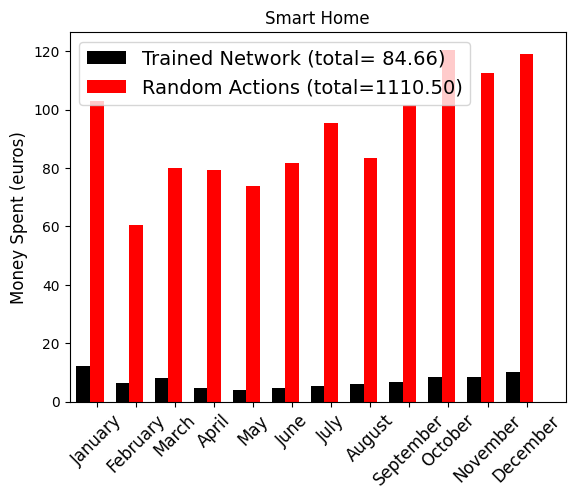

In [ ]:

histo_plotter = HistoPlotter()
monthly_total_list_dqn, _, _, _, _, _, _, _ = test_models( _get_action_dqn, network_name="trained_models/neural_network_dqn_ep300.h5" )
monthly_total_list_random, _, _, _, _, _, _, _ = test_models( _get_action_random, network_name="trained_models/neural_network_dqn_ep300.h5" )
histo_plotter.trained_list = monthly_total_list_dqn
histo_plotter.random_list = monthly_total_list_random
histo_plotter.plot()


In this visual representation, we juxtapose the performance of a random agent against a trained agent utilizing DNQ. Our agent demonstrated superior efficiency by reducing the expenditure on energy. However, this outcome invites scrutiny due to the fact that our reward function does not converge to zero, indicating potential issues with the utilization of the home or the electric vehicle (EV). While we managed to spend less than the random agent, it is noteworthy that there are instances when the EV cannot be utilized, introducing a nuanced aspect to the evaluation.

#### Plot graph of battery_charge

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-7-7e18a2be0358>:43: DeprecationWarning: This function is deprecated. Please call randint(1, 12 + 1) instead
  self.month = np.random.random_integers(1, 12)
<ipython-input-7-7e18a2be0358>:44: DeprecationWarning: This function is deprecated. Please call randint(1, 28 + 1) instead
  self.day = np.random.random_integers(1, Constant.MONTHS_LEN[self.month-1])
<ipython-input-7-7e18a2be0358>:45: DeprecationWarning: This function is deprecated. Please call randint(0, 23 + 1) instead
  self.time = np.random.random_integers(0, 23)


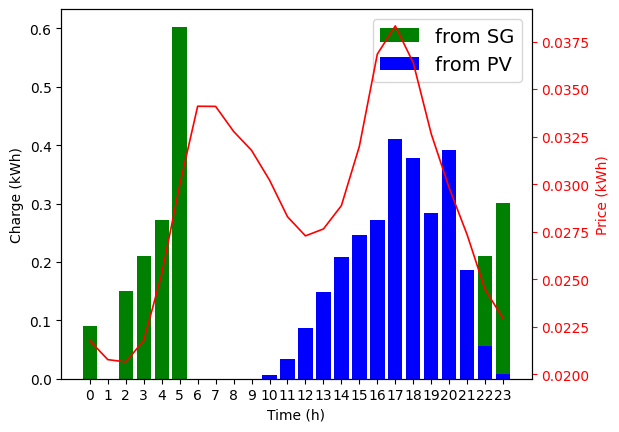

In [ ]:

_, _, hourly_home_battery__dqn, hourly_ev_battery__dqn, hourly_price_dqn, hourly_charge_dqn_sg, hourly_charge_dqn_pv, _ = test_models( _get_action_dqn, network_name="trained_models/neural_network_dqn_ep300.h5" )
line_plotter = DoubleLinePlotter( hourly_home_battery__dqn, hourly_ev_battery__dqn, hourly_price_dqn, hourly_charge_dqn_sg, hourly_charge_dqn_pv )
line_plotter.plot()


In this graphical depiction, the RL agent exhibits a strategic behavior aligned with our desired objective. It prioritizes charging the battery during periods of inexpensive electricity, ensuring readiness for usage during more expensive time slots. As a result, all Smart Grid charging activities occur during the night, specifically between 10 pm and 5 am.

Throughout the day, the agent now leans towards utilizing Photovoltaic (PV) sources, a cost-effective approach aimed at minimizing overall expenses.

#### Plot graph of reward function

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


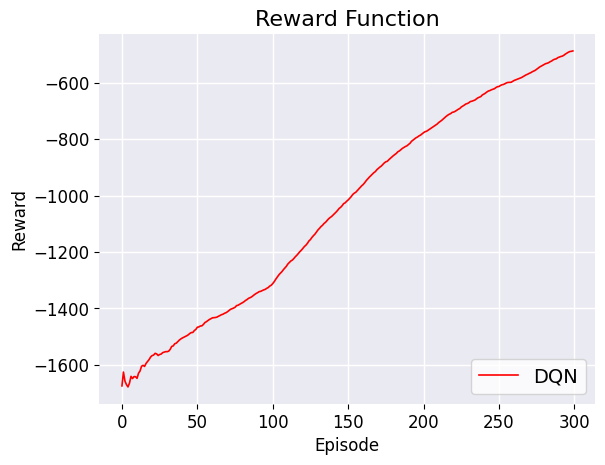

In [ ]:
plotter = LinePlotter(x_label="Episode", y_label="Reward", title="Reward Function")
plotter.load_array([ glob.glob("data/reward_DQN_*.txt") ])
plotter.process_data( rolling_window=100, starting_pointer=0 )
plotter.render( labels=["DQN"], colors=["r"] )

#### Plot graph of consumer demands

<ipython-input-7-7e18a2be0358>:43: DeprecationWarning: This function is deprecated. Please call randint(1, 12 + 1) instead
  self.month = np.random.random_integers(1, 12)
<ipython-input-7-7e18a2be0358>:44: DeprecationWarning: This function is deprecated. Please call randint(1, 30 + 1) instead
  self.day = np.random.random_integers(1, Constant.MONTHS_LEN[self.month-1])
<ipython-input-7-7e18a2be0358>:45: DeprecationWarning: This function is deprecated. Please call randint(0, 23 + 1) instead
  self.time = np.random.random_integers(0, 23)


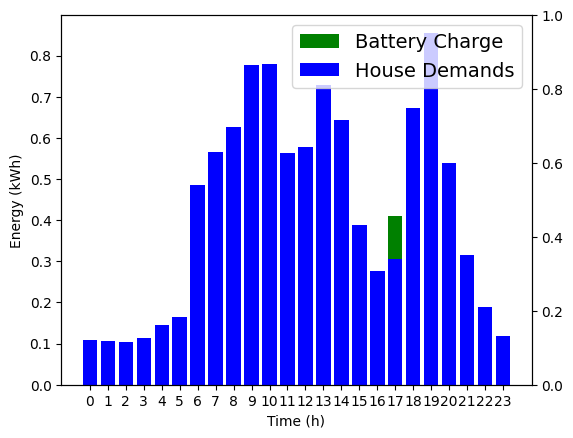

In [ ]:

_, _, hourly_home_battery__dqn, hourly_ev_battery__dqn, hourly_price_dqn, hourly_charge_dqn_sg, hourly_charge_dqn_pv, house_demands = test_models( _get_action_dqn, network_name="trained_models/neural_network_dqn_ep300.h5" )

line_plotter = DemandsPlotter(house_demands, hourly_charge_dqn_pv)
line_plotter.plot()


#### Plot graph of generation

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-7-7e18a2be0358>:43: DeprecationWarning: This function is deprecated. Please call randint(1, 12 + 1) instead
  self.month = np.random.random_integers(1, 12)
<ipython-input-7-7e18a2be0358>:44: DeprecationWarning: This function is deprecated. Please call randint(1, 31 + 1) instead
  self.day = np.random.random_integers(1, Constant.MONTHS_LEN[self.month-1])
<ipython-input-7-7e18a2be0358>:45: DeprecationWarning: This function is deprecated. Please call randint(0, 23 + 1) instead
  self.time = np.random.random_integers(0, 23)


[-48.55280055220641, -48.642447210194256, -48.662728906847605, -48.557756442618995, -48.42447558877486, -48.518395241083844, -48.61333905473672, -48.77176534940004, -48.92247001402179, -49.04614083511131, -49.17205722515544, -49.275368438636676, -49.33619203955454, -49.34517377441321, -49.30979599252683, -49.22566139742548, -49.08510663755628, -48.8154099980311, -48.57432467389617, -48.47294606414211, -48.35130906551679, -48.297930747425106, -48.3508017729211, -48.45488932713379]
(24,)
(24,)
(24,)


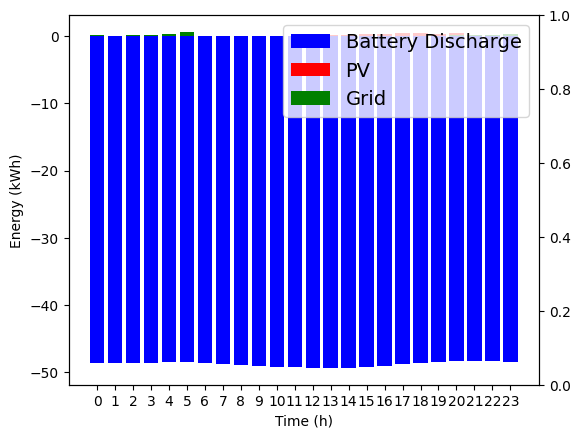

In [ ]:

_, _, hourly_home_battery__dqn, hourly_ev_battery__dqn, hourly_price_dqn, hourly_charge_dqn_sg, hourly_charge_dqn_pv, house_demands = test_models( _get_action_dqn, network_name="trained_models/neural_network_dqn_ep300.h5" )

for i in range(len(hourly_home_battery__dqn)):
  hourly_home_battery__dqn[i] -= 50
print(hourly_home_battery__dqn)
print(np.array(hourly_home_battery__dqn).shape)
print(np.array(hourly_charge_dqn_pv).shape)
print(np.array(hourly_charge_dqn_sg).shape)
line_plotter = GenerationPlotter(hourly_charge_dqn_pv, hourly_charge_dqn_sg, hourly_home_battery__dqn)
line_plotter.plot()



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
